# LoC image analysis

This notebook is designed to take the raw output of a LoC data set, monolayer or bilayer, and:

1. Load the .vsi images as tiffs
2. Process them into Dask arrays
3. Segment
4. Save out the masks
5. Localise and measure properties
6. Unite the localisations over the z-range
7. Save out the Z-tracks
8. Extract the maximum intensity from each cell

In [1]:
import os
import glob
from octopusheavy import DaskOctopusHeavyLoader
import napari

In [2]:
import dask.array as da
import napari
import btrack
from tqdm.auto import tqdm
from skimage.io import imshow,  imsave, imread
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import itertools
import json

plt.rcParams["figure.figsize"] = (15,7)

# Loading images

Define root path and individual experiment IDs

In [3]:
root_path = '/run/user/30046150/gvfs/smb-share:server=data.thecrick.org,share=lab-gutierrezm/home/shared/Lung on chip/Light microscopy'

In [4]:
expt_IDs = ['co-culture/iVECs+iAT2AT1/Folder_20220808/A2-A5/analysis_20221125/DAPI-SPC-PDPN-ZO1/_20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_60_/images/',
            'co-culture/iVECs+iAT2AT1/Folder_20220808/A2-A5/analysis_20221125/DAPI-VWF-iCAM1-ZO1/_20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_70_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-AQP5-proSPC-ZO1/Day7_static/_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_150_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-AQP5-proSPC-ZO1/Day14_static/_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_262_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-CAV1-proSPC-ZO1/Day7_static/_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_130_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-CAV1-proSPC-ZO1/Day14_static/_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_253_/images/'
           ]

## Check to see what channels each expt has

In [32]:
for i, expt in enumerate(expt_IDs):
    images = DaskOctopusHeavyLoader(os.path.join(root_path, expt), remove_background=False)
    if 'MASK1' not in [channel.name for channel in images.channels]:
        print(i, images.channels)

0 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>]
1 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>]
3 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>]
5 [<Channels.CH1: 1>, <Channels.CH2: 2>, <Channels.CH3: 3>, <Channels.CH4: 4>]


In [6]:
import napari 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


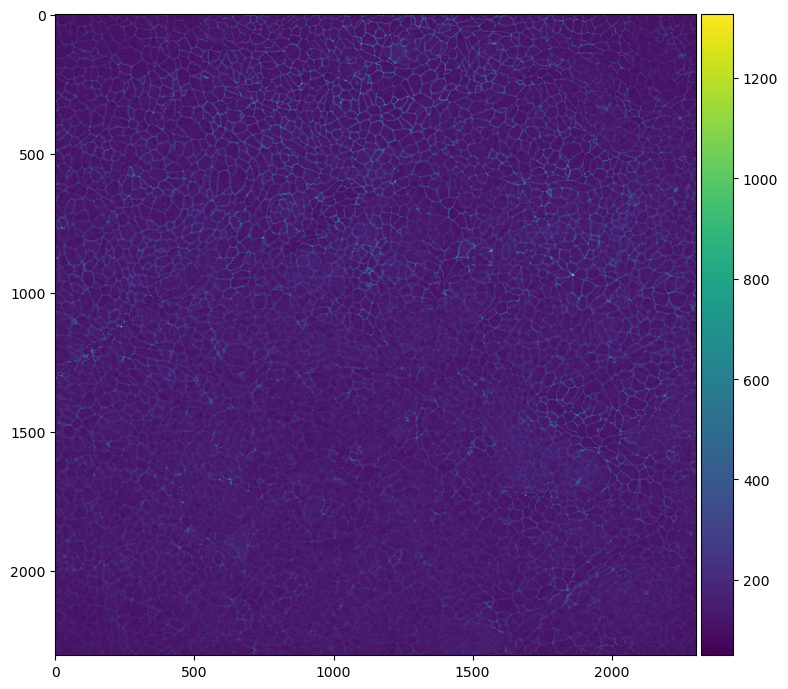

In [35]:
imshow(images['CH4'][30])

In [7]:
images = DaskOctopusHeavyLoader(os.path.join(root_path, expt_IDs[2]), remove_background=False)

In [8]:
v = napari.Viewer()

v.add_image(images['ch1'], blending = 'additive', colormap='green')
v.add_image(images['ch2'], blending = 'additive', colormap='red')
v.add_image(images['ch3'], blending = 'additive', colormap='blue')
v.add_image(images['ch4'], blending = 'additive', colormap='yellow')
v.add_labels(images['mask1'])



Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'Labels' at 0x7feb6a871cd0>

# Segment images

###### Initialise gpu

In [11]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob
from skimage.io import imread, imsave
from tqdm.auto import tqdm

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Thu Dec  1 15:19:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 30%   31C    P8    30W / 300W |   4704MiB / 49140MiB |      7%      Default |
|                               |                      |                  N/A |
+

In [47]:
%%time
# define model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type='cyto')
# define CHANNELS to run segementation on
channels = [0,0]
### define empty mask stack 
mask_stack = []
for i, expt in tqdm(enumerate(expt_IDs), total = len(expt_IDs)):
    images = DaskOctopusHeavyLoader(os.path.join(root_path, expt), remove_background=False)
    if 'MASK1' not in [channel.name for channel in images.channels]: 
        ### iterate over frames
        for image, fn in tqdm(zip(images['CH4'], images.files('CH4')), total = len(images['CH4'])):
            ### run segmentation
            masks, flows, styles, diams = model.eval(image, diameter=None, flow_threshold=None, channels=channels)
            ### rename and save out
            fn = fn.replace('c004', 'c099')
            imsave(fn, masks, check_contrast=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: Ru

  0%|          | 0/81 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: Ru

  0%|          | 0/81 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: Ru

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: Ru

  0%|          | 0/81 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: Ru

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: Ru

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 48min 11s, sys: 9min 17s, total: 57min 28s
Wall time: 1h 1min 17s


### Defining properties to measure similarities of z-slices

In [ ]:
props = ('axis_major_length', 
         'axis_minor_length', 
         'eccentricity', 
         'area', 
         'mean_intensity', 
         #'intensity_image', 
         'orientation')image

In [ ]:
%%time
objects = btrack.utils.segmentation_to_objects(
    image['CH99'], 
    ch0,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
# ch0_objects = [obj for obj in ch0_objects if obj.properties['area'] > 50]


#### is there a better way to do this? ie. multiple channels measured in one localisation step?

In [ ]:
from skimage.measure import regionprops_table

In [ ]:
image[0].shape

In [ ]:
help(regionprops_table)

In [ ]:
regionprops_table(mask_stack[0], image[0], properties = props)

##### Tracking objs

In [ ]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
  # configure the tracker using a config file
  tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
  # append the objects to be tracked
  tracker.append(ch1_objects)
  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2304), (0, 2304))
  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)
  # generate hypotheses and run the global optimizer
  tracker.optimize()
  # get the tracks as a python list
  ch1_tracks = tracker.tracks
  # filter tracks
  ch1_tracks = [track for track in ch1_tracks if len(track) >= 3]
  # optional: get the data in a format for napari
  ch1_data, properties, graph = tracker.to_napari()

In [ ]:
import pandas as pd

In [ ]:
import xlsxwriter

In [ ]:
track

In [ ]:
list(track.to_dict().keys())

In [ ]:
test = pd.DataFrame(track.to_dict(), columns = list(track.to_dict().keys()))

In [ ]:
# writer = pd.ExcelWriter('/run/user/30046150/gvfs/google-drive:host=gmail.com,user=nthndy/channel1.xlsx', engine='xlsxwriter')
writer = pd.ExcelWriter('/mnt/DATA/sandbox/lung_on_chip/monolayer/initial_tracks/channel1.xlsx', engine='xlsxwriter')
for track in tqdm(ch1_tracks, total = len(ch1_tracks)):
    df = pd.DataFrame(track.to_dict(), columns = list(track.to_dict().keys()))
    df.to_excel(writer, sheet_name = f'track_{track.ID}')
writer.save()

writer = pd.ExcelWriter('/mnt/DATA/sandbox/lung_on_chip/monolayer/initial_tracks/channel2.xlsx', engine='xlsxwriter')
for track in tqdm(ch2_tracks, total = len(ch2_tracks)):
    df = pd.DataFrame(track.to_dict(), columns = list(track.to_dict().keys()))
    df.to_excel(writer, sheet_name = f'track_{track.ID}')
writer.save()

#### Data pruning

Lots of dummy instances in these tracks which poses the question of whether they should be included at all?

Shall I filter based on border effects?

What about time?

What about MSD?

In [ ]:
ch2_dummy_count = 0
ch1_dummy_count = 0
ch2_tracks_final, ch1_tracks_final = [], []
for ch2_track, ch1_track in zip(ch2_tracks, ch1_tracks):
    if any(ch2_track.dummy) == True:
        ch2_dummy_count+=1
    else:
        ch2_tracks_final.append(ch2_track)
    if any(ch1_track.dummy) == True:
        ch1_dummy_count+=1
    else:    
        ch1_tracks_final.append(ch1_track)

In [ ]:
track

In [ ]:
max(track.x) - min(track.x)

In [ ]:
msd_dict = {}
for track in ch1_tracks_final:
    dx = max(track.x) - min(track.x)
    dy = max(track.y) - min(track.y)
    
    msd = np.sqrt(dx**2 + dy**2)
    msd_list.append(msd)
    
    msd_dict[track.ID] = msd

In [ ]:
len(ch1_tracks), len(ch2_tracks)

In [ ]:
len(ch1_tracks_final), len(ch2_tracks_final), ch1_dummy_count, ch2_dummy_count

In [ ]:
plt.hist(msd_dict.values(), bins = 75)

In [ ]:
msd_dict

In [ ]:
msd_dict[5560]

In [ ]:
[track for track in ch1_tracks if track.ID == 1530][0]

In [ ]:
ch1_tracks_final[0]

In [ ]:
ch1_tracks[45]

### Filtering track info to only extract single cell information from t (z) = 34

In [ ]:
track

In [ ]:
temp_ch1_list, temp_ch2_list = [], []
for ch1_track, ch2_track in zip(ch1_tracks_final, ch2_tracks_final):
    if 34 in ch1_track.t:
        index = ch1_track.t.index(34)
        x, y, ID = ch1_track.x[index], ch1_track.y[index], ch1_track.ID
        mean_int, area = ch1_track.properties['mean_intensity'][index], ch1_track.properties['area'][index]
        temp_ch1_list.append((ID, x, y, mean_int, area))
    if 34 in ch2_track.t:
        index = ch2_track.t.index(34)
        x, y, ID = ch2_track.x[index], ch2_track.y[index], ch2_track.ID
        mean_int, area = ch2_track.properties['mean_intensity'][index], ch2_track.properties['area'][index]
        temp_ch2_list.append((ID, x, y, mean_int, area))
mean_ch1_int_df = pd.DataFrame(temp_ch1_list, columns=['Cell ID', 'X', 'Y', 'Mean Ch1 Intensity', 'Area'])
mean_ch2_int_df = pd.DataFrame(temp_ch2_list, columns=['Cell ID', 'X', 'Y', 'Mean Ch2 Intensity', 'Area'])

In [ ]:
mean_ch1_int_df

In [ ]:
mean_ch2_int_df

### Save out dataframes as excel sheets

In [ ]:
writer = pd.ExcelWriter('/mnt/DATA/sandbox/lung_on_chip/monolayer/initial_tracks/initial_single_cell_measurements_z34_20x_21-12-031B_A12456.xlsx', engine='xlsxwriter')
mean_ch2_int_df.to_excel(writer, sheet_name = 'channel2')
mean_ch1_int_df.to_excel(writer, sheet_name = 'channel1')
writer.save()

## Checking tracks prior to plotting single cell info

In [ ]:
import napari

In [ ]:
viewer = napari.Viewer()

viewer.add_image(ch0, colormap='blue', blending = 'additive')
viewer.add_image(ch3, colormap= 'gray', blending = 'additive')
viewer.add_image(ch1, colormap='red', blending = 'additive')
viewer.add_image(ch2, colormap= 'green', blending = 'additive')

viewer.add_labels(mask_stack)

viewer.add_tracks(ch1_data)
viewer.add_tracks(ch2_data)


# Extracting single-slice single-cell data

In [ ]:
path = '/mnt/DATA/sandbox/lung_on_chip/monolayer'
fn2 = '20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122.vsi - 014 CF405, CF488, CF561, CF638.tif'
fn3 = '20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236.vsi - 005 CF405, CF488, CF561, CF638.tif'
fn4 = '20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245.vsi - 014 CF405, CF488, CF561, CF638.tif'

In [ ]:
f'_245' in fn2

In [ ]:
### frame_dict is acq_ID:frame of interest
frame_dict = {245:30, 236:37, 122:32}

In [ ]:
masks_list = []
ch1_list = []
ch2_list = []
for fn in [fn2, fn3, fn4]:
    print('Loading file:', os.path.join(path, fn))
    image = imread(os.path.join(path, fn))
    ch1, ch2 = image[1], image[2]
    seg_ch = image[3]
    for dict_entry in frame_dict:
        if f'_{dict_entry}' in fn:
            frame = frame_dict[dict_entry]
    print(f'Loading file at frame {frame}:', os.path.join(path, fn))
    image = imread(os.path.join(path, fn))
    ch1, ch2 = image[...,1][frame], image[...,2][frame]
    seg_ch = image[...,3][frame]
    masks, flows, styles, diams = model.eval(seg_ch, diameter=None, flow_threshold=None, channels=channels)
    masks_list.append(masks)
    ch1_list.append(ch1)
    ch2_list.append(ch2)
print('Masks loaded and segmented')
masks = np.stack(masks_list, axis = 0)
ch1 = np.stack(ch1_list)
ch2 = np.stack(ch2_list)
ch1_objects = btrack.utils.segmentation_to_objects(masks, 
                                                    ch1,
                                                    properties = ('area', 'mean_intensity'), )
ch2_objects = btrack.utils.segmentation_to_objects(masks, 
                                                    ch2,
                                                    properties = ('area', 'mean_intensity'), )

### Each time slice in these 2 sets of objects corresponds to a different membrane

In [ ]:
_122_ch1_list, _236_ch1_list, _245_ch1_list = [], [], []
for obj in ch1_objects:
    x, y, ID = obj.x, obj.y, obj.ID
    t = obj.t
    mean_int, area = obj.properties['mean_intensity'], obj.properties['area']
    if t == 0:
        _122_ch1_list.append((ID, x, y, mean_int, area))
    if t == 1:
        _236_ch1_list.append((ID, x, y, mean_int, area))
    if t == 2:
        _245_ch1_list.append((ID, x, y, mean_int, area))
_122_mean_ch1_int_df = pd.DataFrame(_122_ch1_list, columns=['Cell ID', 'X', 'Y', 'Mean Ch1 Intensity', 'Area'])
_236_mean_ch1_int_df = pd.DataFrame(_236_ch1_list, columns=['Cell ID', 'X', 'Y', 'Mean Ch1 Intensity', 'Area'])
_245_mean_ch1_int_df = pd.DataFrame(_245_ch1_list, columns=['Cell ID', 'X', 'Y', 'Mean Ch1 Intensity', 'Area'])

In [ ]:
_122_ch2_list, _236_ch2_list, _245_ch2_list = [], [], []
for obj in ch2_objects:
    x, y, ID = obj.x, obj.y, obj.ID
    t = obj.t
    mean_int, area = obj.properties['mean_intensity'], obj.properties['area']
    if t == 0:
        _122_ch2_list.append((ID, x, y, mean_int, area))
    if t == 1:
        _236_ch2_list.append((ID, x, y, mean_int, area))
    if t == 2:
        _245_ch2_list.append((ID, x, y, mean_int, area))
_122_mean_ch2_int_df = pd.DataFrame(_122_ch2_list, columns=['Cell ID', 'X', 'Y', 'Mean ch2 Intensity', 'Area'])
_236_mean_ch2_int_df = pd.DataFrame(_236_ch2_list, columns=['Cell ID', 'X', 'Y', 'Mean ch2 Intensity', 'Area'])
_245_mean_ch2_int_df = pd.DataFrame(_245_ch2_list, columns=['Cell ID', 'X', 'Y', 'Mean ch2 Intensity', 'Area'])

In [ ]:
ch1_df = _122_mean_ch1_int_df
ch2_df = _122_mean_ch2_int_df
writer = pd.ExcelWriter('/mnt/DATA/sandbox/lung_on_chip/monolayer/initial_tracks/initial_single_cell_measurements_z32_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122.vsi - 014 CF405, CF488, CF561, CF638.xlsx', engine='xlsxwriter')
ch2_df.to_excel(writer, sheet_name = 'channel2')
ch1_df.to_excel(writer, sheet_name = 'channel1')
writer.save()

In [ ]:
ch1_df = _236_mean_ch1_int_df
ch2_df = _236_mean_ch2_int_df
writer = pd.ExcelWriter('/mnt/DATA/sandbox/lung_on_chip/monolayer/initial_tracks/initial_single_cell_measurements_z37_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236.vsi - 005 CF405, CF488, CF561, CF638.xlsx', engine='xlsxwriter')
ch2_df.to_excel(writer, sheet_name = 'channel2')
ch1_df.to_excel(writer, sheet_name = 'channel1')
writer.save()

In [ ]:
ch1_df = _245_mean_ch1_int_df
ch2_df = _245_mean_ch2_int_df
writer = pd.ExcelWriter('/mnt/DATA/sandbox/lung_on_chip/monolayer/initial_tracks/initial_single_cell_measurements_z30_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245.vsi - 014 CF405, CF488, CF561, CF638.xlsx', engine='xlsxwriter')
ch2_df.to_excel(writer, sheet_name = 'channel2')
ch1_df.to_excel(writer, sheet_name = 'channel1')
writer.save()